In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data.csv")
data = data[data['species_name'] == "Sus cebifrons (Visayan Warty Pig)"]
data=data[['date_report','no_observation']]
data.head()

,date_report,no_observation
4,2016-01-25,13
7,2016-01-25,12
12,2016-02-22,13
15,2016-02-22,15
20,2016-03-21,13


In [3]:
data.index = pd.to_datetime(data['date_report'])
data.drop(columns='date_report',inplace=True)
data.head()
data = data.resample('M').sum()
data

,no_observation
date_report,
2016-01-31,25
2016-02-29,28
2016-03-31,24
2016-04-30,18
2016-05-31,16
...,...
2021-08-31,15
2021-09-30,14
2021-10-31,17


In [4]:
data.isna().sum()

no_observation    0
dtype: int64

<AxesSubplot:xlabel='date_report'>

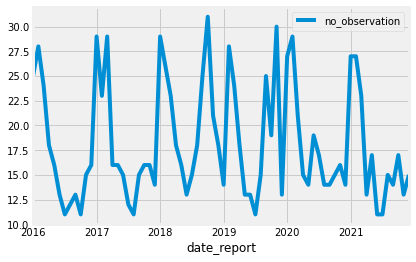

In [5]:
data.plot()

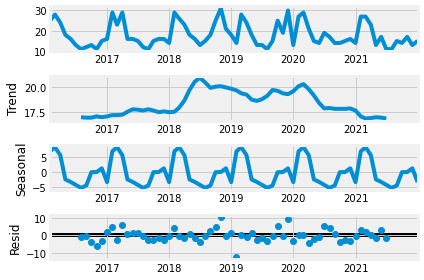

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data, model="additive")
decompose_data.plot();

<AxesSubplot:xlabel='date_report'>

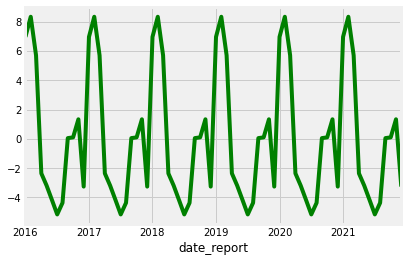

In [7]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [8]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.no_observation, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.5547631496987426
2. P-Value :  0.5062680845992241
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776


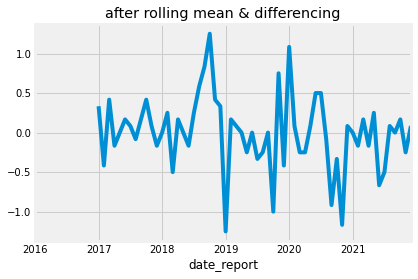

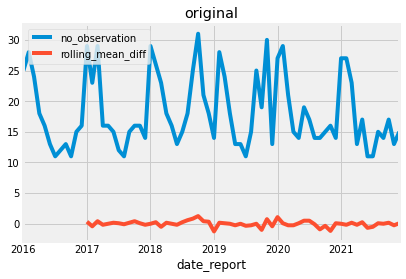

In [9]:
rolling_mean = data.rolling(window = 12).mean()
data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
data.plot(title='original');

In [10]:
dftest = adfuller(data['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -4.417965344484826
2. P-Value :  0.000275839820399653
3. Num Of Lags :  2
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 57
5. Critical Values :
	 1% :  -3.5506699942762414
	 5% :  -2.913766394626147
	 10% :  -2.5946240473991997


In [11]:
from pmdarima import auto_arima

Sarimax_model = auto_arima(data.no_observation,
                       start_p=0,
                       start_q=0,
                       max_p=3,
                       max_q=3,
                       m=12,
                       test='adf',
                       seasonal=True,
                       d=1,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=409.225, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=382.025, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=386.932, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=370.037, Time=0.38 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=384.819, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=371.414, Time=0.64 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=366.046, Time=1.18 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=384.025, Time=0.22 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=3.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=364.686, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -178.343
Date:                             Sun, 28 Nov 2021   AIC                            364.686
Time:                                     11:12:13   BIC                            372.996
Sample:                                          0   HQIC                           367.930
                                              - 72                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8466      0.097     -8.712      0.000      -1.037      -0.656
ar.S.L12      -0.5137      0.133     -3.868      0.000      -0.774      -0.253
ar.S.L24      -0.5603      0.132     -4.234      0.000      -0.820      -0.301
sigma2        20.2278      3.563      5.676      0.000      13.244      27.212
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                21.36
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -0.29
Prob(H) (two-sided):                  0.51   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model=ARIMA(data['no_observation'],order=(0,1,1))
history=model.fit()

In [13]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.no_observation   No. Observations:                   71
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -225.569
Method:                       css-mle   S.D. of innovations              5.796
Date:                Sun, 28 Nov 2021   AIC                            457.138
Time:                        11:12:14   BIC                            463.926
Sample:                    02-29-2016   HQIC                           459.838
                         - 12-31-2021                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1517      0.457     -0.332      0.740      -1.047       0.744
ma.L1.D.no_observation    -0.3409      0.145     -2.352      0.019      -0.625      -0.057
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            2.9338           +0.0000j            2.9338            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='date_report'>

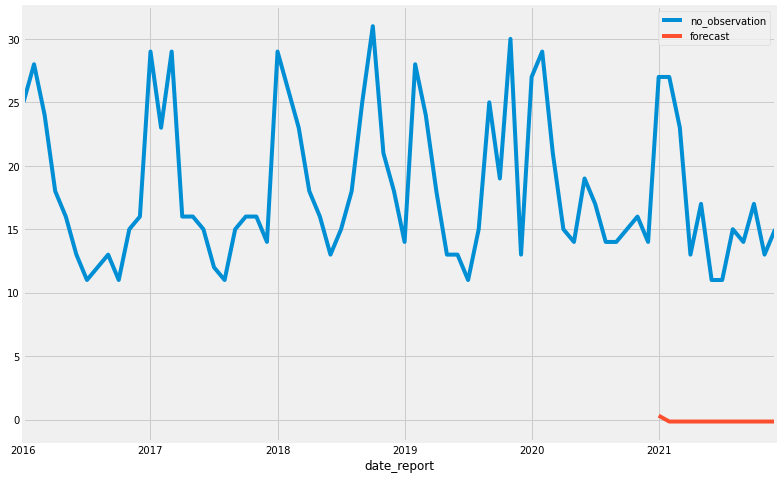

In [14]:
model_fit=model.fit()
data['forecast']=model_fit.predict(start=60,end=72,dynamic=True)
data[['no_observation','forecast']].plot(figsize=(12,8))

In [15]:
model=ARIMA(data['rolling_mean_diff'].dropna(),order=(0,1,1))
model_fit=model.fit()

<AxesSubplot:xlabel='date_report'>

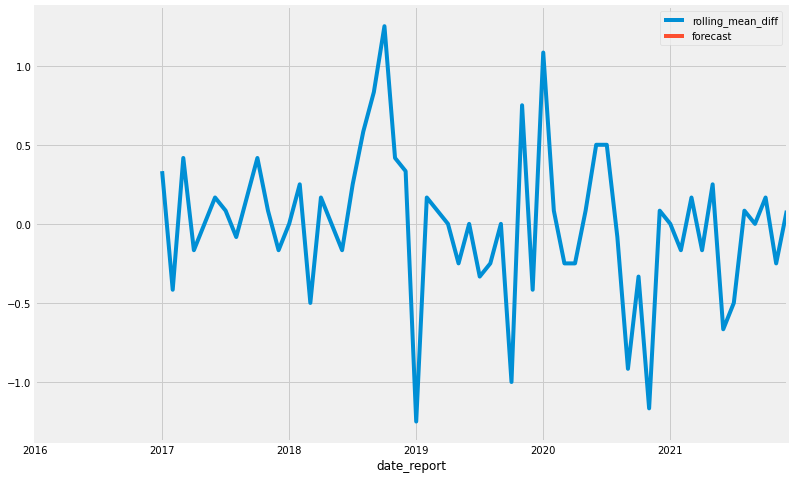

In [16]:
data['forecast']=model_fit.predict(start=60,end=72,dynamic=True)
data[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

In [17]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['no_observation'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

<AxesSubplot:xlabel='date_report'>

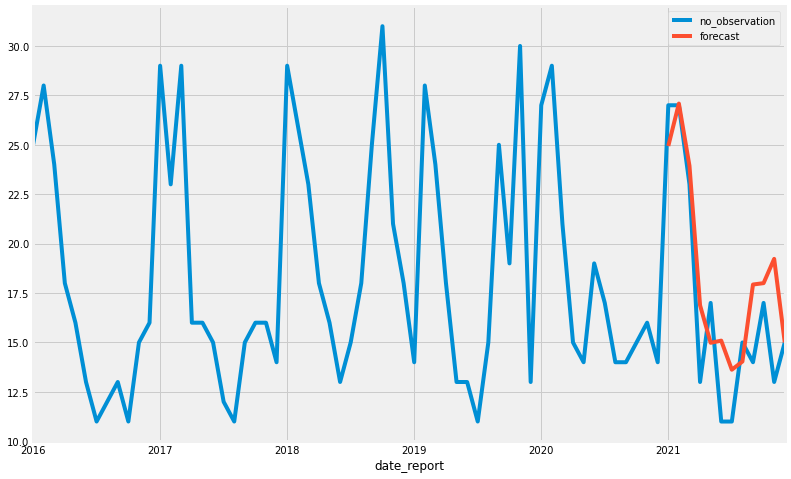

In [18]:
data['forecast']=results.predict(start=60,end=72,dynamic=True)
data[['no_observation','forecast']].plot(figsize=(12,8))

In [19]:
s_residuals = data['no_observation'] -data['forecast']

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(s_residuals/data.no_observation)),2))

Mean Absolute Percent Error: 0.17


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(s_residuals**2)))

Root Mean Squared Error: 2.9447779880173472


In [22]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [23]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,no_observation,rolling_mean_diff,forecast
2022-01-31,NaN,NaN,NaN
2022-02-28,NaN,NaN,NaN
2022-03-31,NaN,NaN,NaN
2022-04-30,NaN,NaN,NaN
2022-05-31,NaN,NaN,NaN
2022-06-30,NaN,NaN,NaN
2022-07-31,NaN,NaN,NaN
2022-08-31,NaN,NaN,NaN
2022-09-30,NaN,NaN,NaN
2022-10-31,NaN,NaN,NaN


In [24]:
data=pd.concat([data,pred_date])

,no_observation,rolling_mean_diff,forecast
2016-01-31,25,NaN,NaN
2016-02-29,28,NaN,NaN
2016-03-31,24,NaN,NaN
2016-04-30,18,NaN,NaN
2016-05-31,16,NaN,NaN
...,...,...,...
2023-07-31,NaN,NaN,11.359428
2023-08-31,NaN,NaN,12.747282
2023-09-30,NaN,NaN,16.109272
2023-10-31,NaN,NaN,16.627431


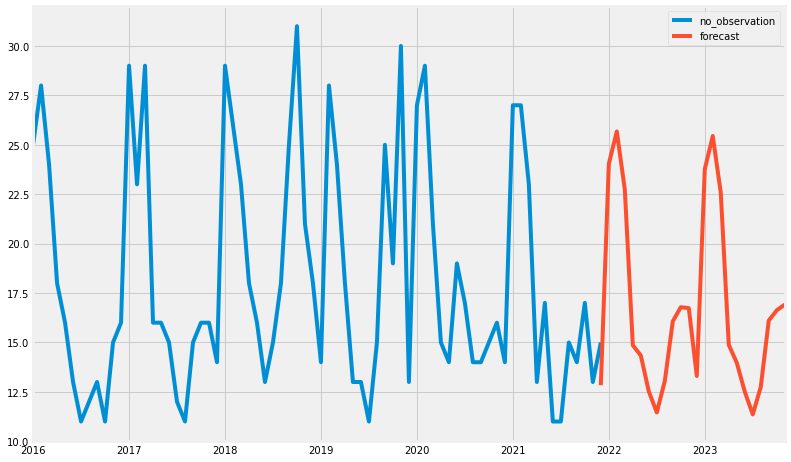

In [25]:
data['forecast'] = results.predict(start = 71, end = 96, dynamic= True)  
data[['no_observation', 'forecast']].plot(figsize=(12, 8))
data

In [26]:
data.tail(24)

,no_observation,rolling_mean_diff,forecast
2021-12-31,15,0.083333,12.836545
2022-01-31,NaN,NaN,24.038363
2022-02-28,NaN,NaN,25.674714
2022-03-31,NaN,NaN,22.729364
2022-04-30,NaN,NaN,14.857358
2022-05-31,NaN,NaN,14.340906
2022-06-30,NaN,NaN,12.520958
2022-07-31,NaN,NaN,11.458712
2022-08-31,NaN,NaN,13.052391
2022-09-30,NaN,NaN,16.070680
